Trajectory analysis of endothelial cells (figure2). This analysis rely on moscot, jax, ott wot and toytree. Please install the appropriate version of the package as follow. One can refer to these two articles if you want to learn more about the OT algorithm and its applications, [Schiebinger 2019](https://doi.org/10.1016/j.cell.2019.01.006) and [Klein](https://doi.org/10.1038/s41586-024-08453-2).

In [1]:
# pip install moscot==0.3.5 jax==0.4.38 ott-jax==0.4.6 toytree==2.0.5 wot

In [2]:
import sys,warnings
sys.path.append('/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/') # change to the path where devendo.py stript located.
sys.path.append('/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/Treesing/') # change to the path where treesing.py stript located.
import devendo as de
import treesing as ti
import numpy as np
import pandas as pd
import scanpy as sc
import wot
import matplotlib.pyplot as plt
import anndata, re,os
import seaborn as sns
from scipy.sparse import csr_matrix,csc_matrix, find
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load STED-EC dataset

The expression matrix can be download from [figshare](https://figshare.com/account/items/30689990/edit). The lognormal matrix is stored in adata.X, and the raw count matrix is stored in adata.raw.X. The adata.obs['label'] present the cell type label, and the adata.obs['organ'] present the organ label.

In [3]:
adata = sc.read_h5ad('DATA/sted-ec.h5ad')

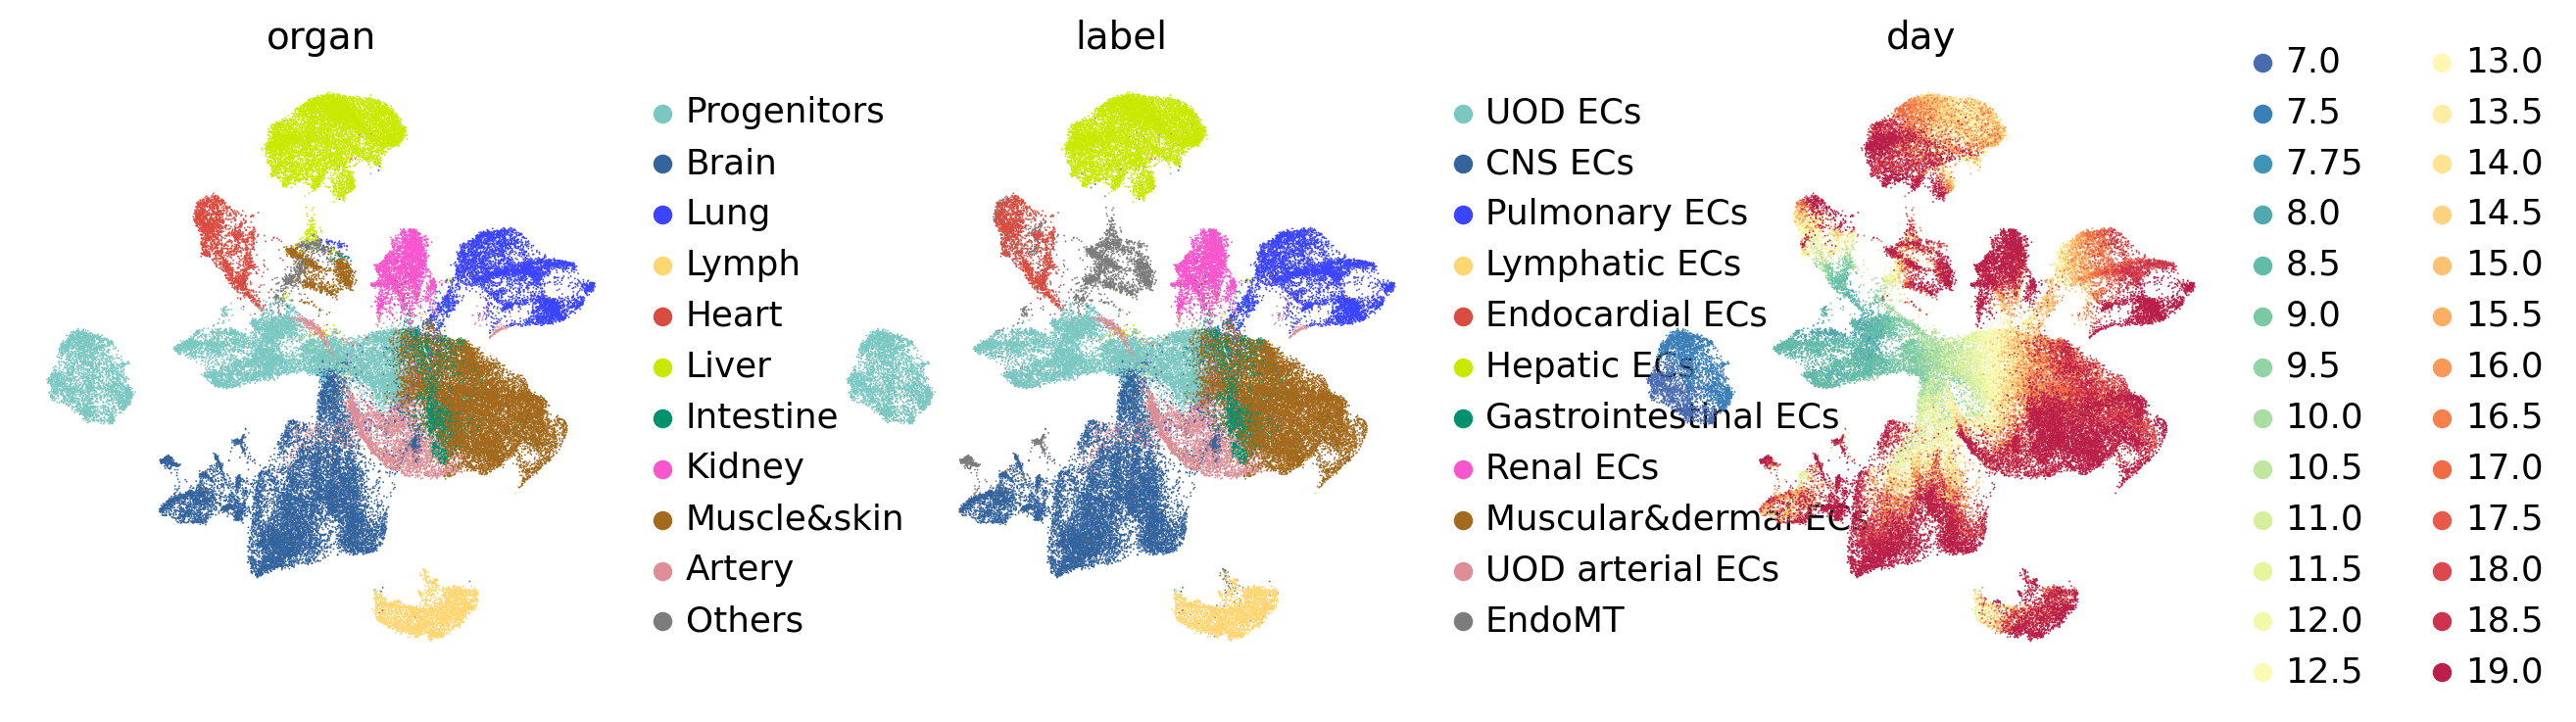

In [4]:
sc.pl.umap(adata, color = ['organ','label','day'], frameon=False)

Now we visualize the cells across continuous time points, with cell types represented by colors.

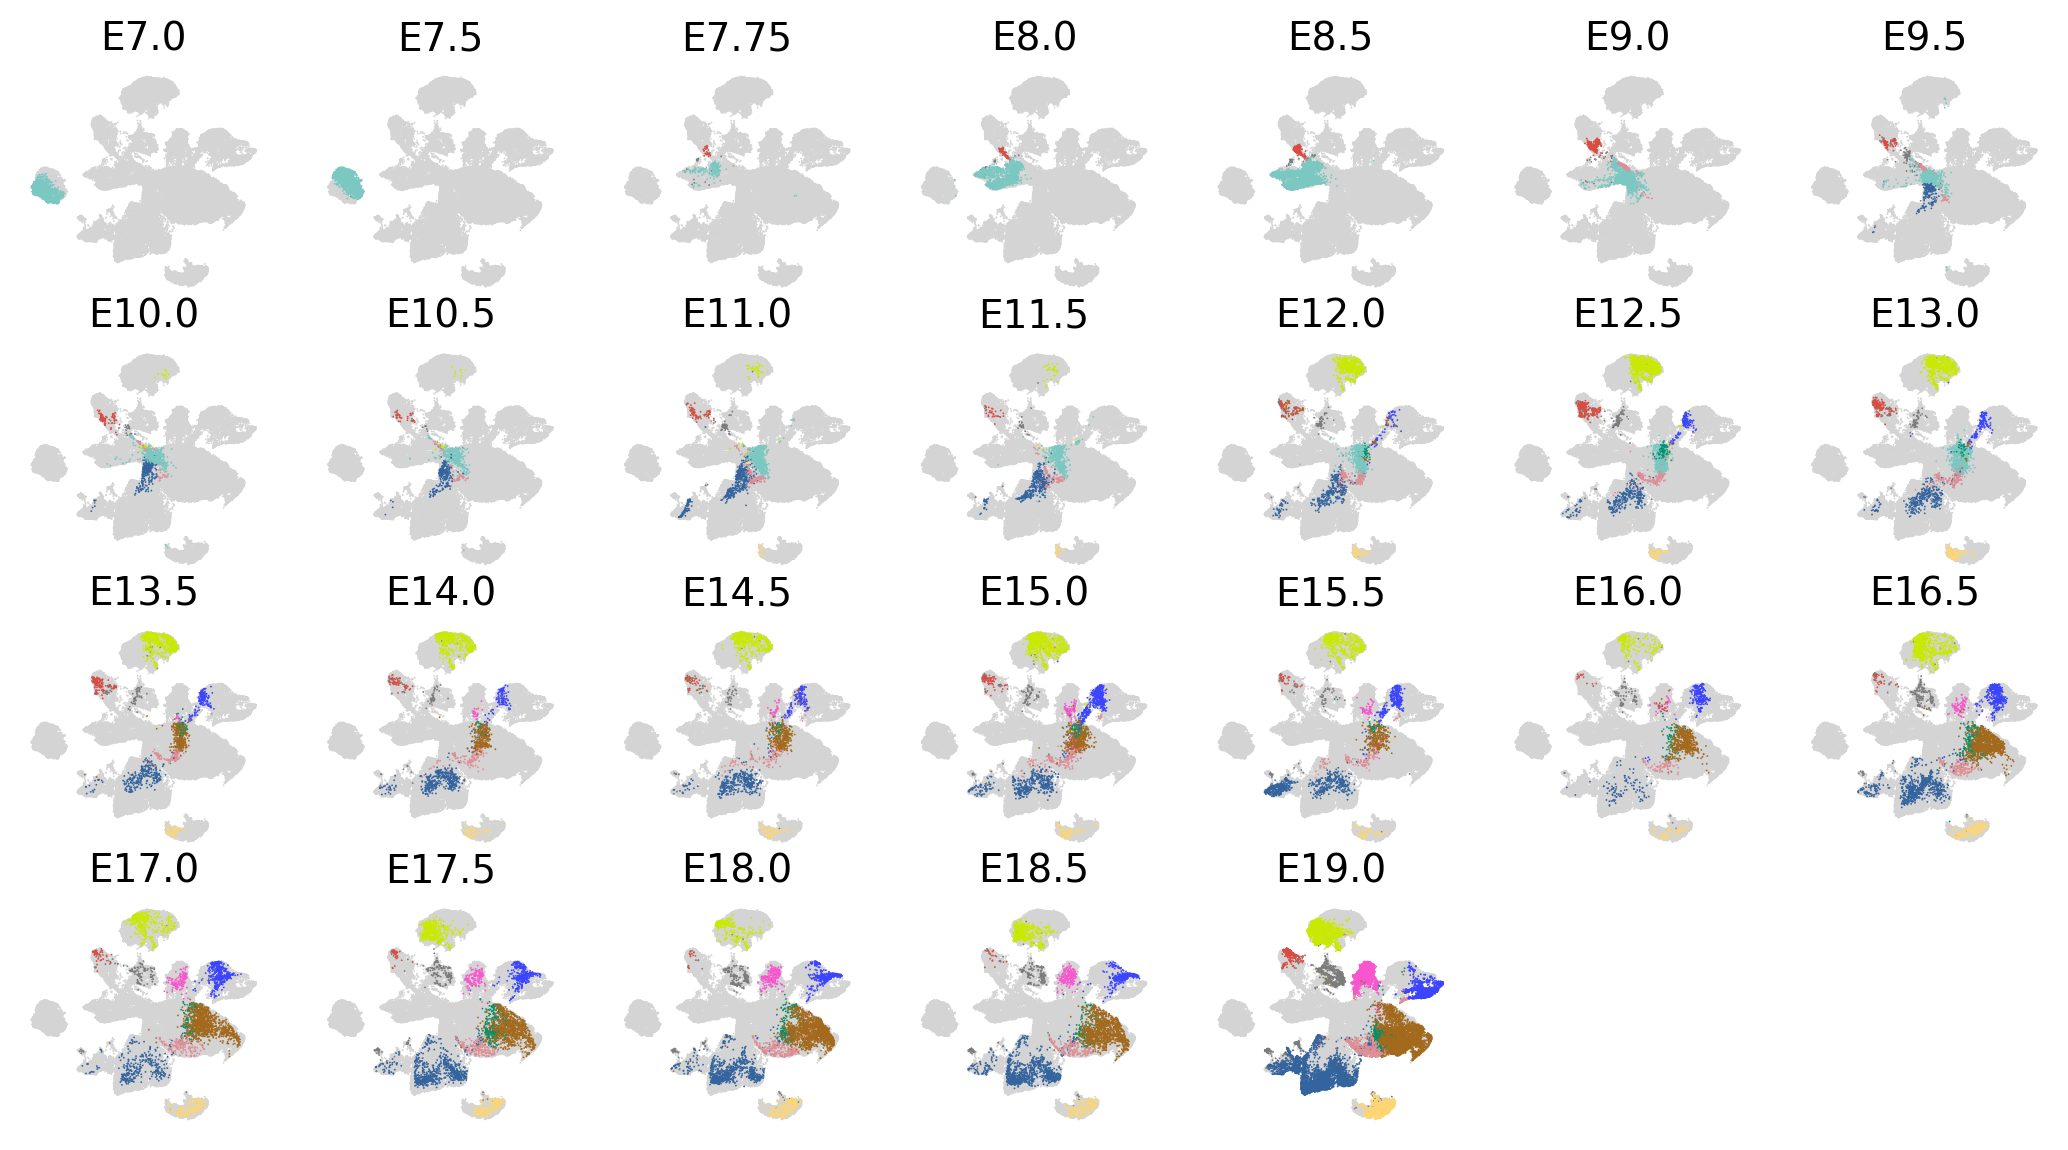

In [5]:
de.highLightGroup(adata, 'embryonic_period',label = 'label',label_color = None,frameon = False, ncol = 7, figsize = (13,7))

In [6]:
merge_stages = np.array(['E18.0-E19.0']*adata.shape[0], dtype = '<U20')
merge_stages[adata.obs['embryonic_period'].isin(['E7.0','E7.5'])] = 'E7.0-E7.5'  
merge_stages[adata.obs['embryonic_period'].isin(['E7.75','E8.0','E8.5','E8.0','E9.0','E9.5'])] = 'E7.75-E9.5'  
merge_stages[adata.obs['embryonic_period'].isin(['E10.0','E10.5','E11.0','E11.5',])] = 'E10.0-E11.5'
merge_stages[adata.obs['embryonic_period'].isin(['E12.0','E12.5','E13.0','E13.5','E14.0','E14.5'])] = 'E12.0-E14.5'
merge_stages[adata.obs['embryonic_period'].isin(['E15.0','E15.5','E16.0','E16.5','E17.0','E17.5'])] = 'E15.0-E17.5'
adata.obs['merge_stages'] = pd.Categorical(merge_stages, ['E7.0-E7.5','E7.75-E9.5','E10.0-E11.5','E12.0-E14.5','E15.0-E17.5','E18.0-E19.0'])

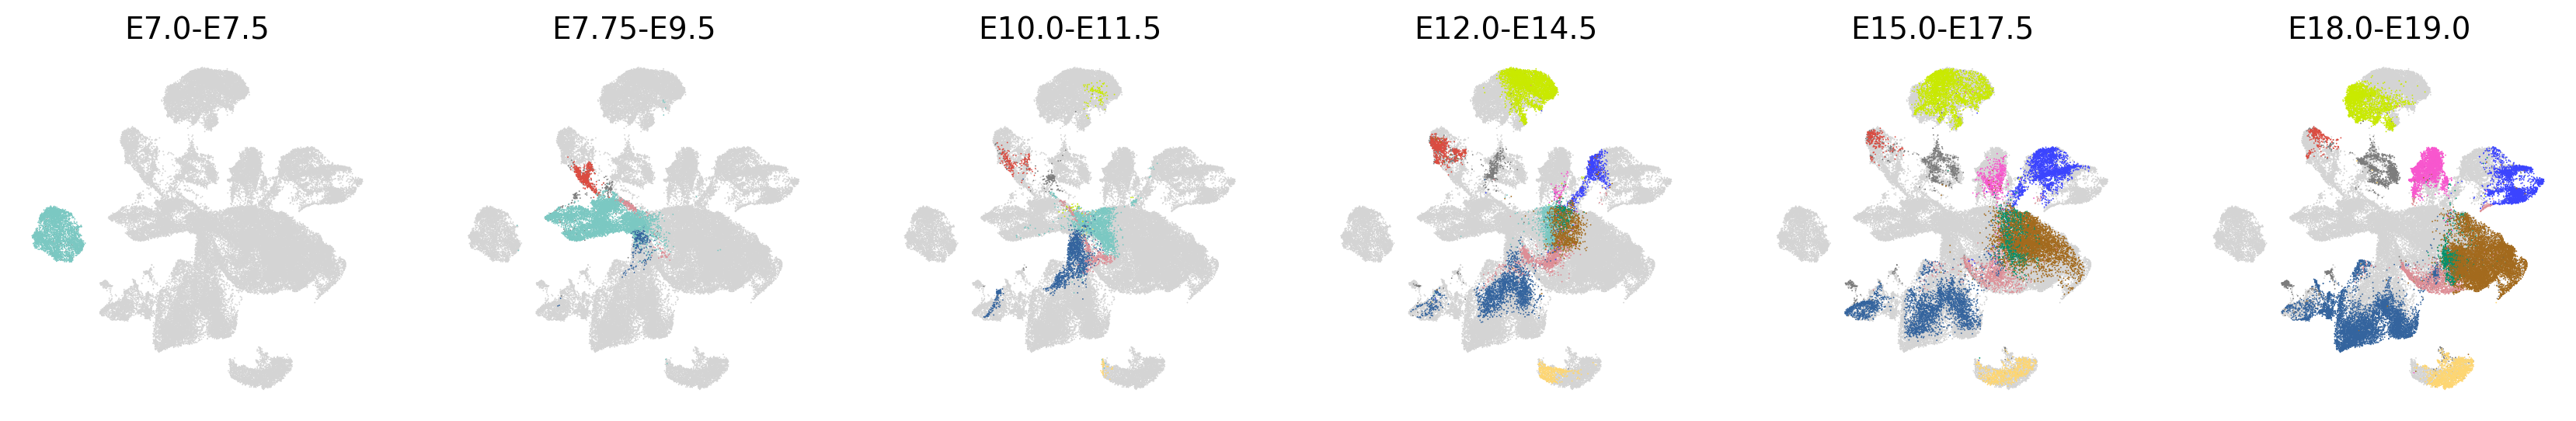

In [7]:
de.highLightGroup(adata, 'merge_stages',label = 'label',label_color = None,frameon = False, ncol = 6, figsize = (21,3))

## 2. Inference the trajectory

We infer the ancestor and descendant cells day by day. Note that we require the data to contain labels for time points (in float format) and cell annotations (or clustering labels).

In [9]:
tfs = pd.read_csv('DATA/Mouse_TFs.csv')['Symbol'].values

In [10]:
deg = de.FindAllMarkers(adata, 'label')

Calculate DEGs...


The union gene set of TFs and DEGs were used for inference

In [11]:
features = np.unique(np.concatenate([tfs,deg['names']]))

Run optimal-transport and save the 

Here, we use mocot to calculate the cell transition matrix between adjacent time points. Cells from any two time points are extracted to recalculate PCA and CCA dimensionality reduction before perform optimal-transport, we believe this approach can capture the information between adjacent time points. The results are stored in ./tmaps directory with tag 'ott_cca'.

In [12]:
adata.obs['day']

E7.0_20200112-3_AAGTGAACAAGAAATC     7.0
E7.0_20200112-3_AGAACAATCCGTGTAA     7.0
E7.0_20200112-3_AGATGCTCAAAGTGTA     7.0
E7.0_20200112-3_AGGTTACGTGACGTCC     7.0
E7.0_20200112-3_AGTGTTGCATCTTTCA     7.0
                                    ... 
born_20191230-8_TTGATGGTCATTTGCT    19.0
born_20191230-8_TTTACGTAGTCCGTCG    19.0
born_20191230-8_TTTATGCAGGGAGATA    19.0
born_20191230-8_TTTATGCGTCTCACAA    19.0
born_20191230-8_TTTGTTGAGATTTGCC    19.0
Name: day, Length: 70915, dtype: category
Categories (26, float64): [7.00, 7.50, 7.75, 8.00, ..., 17.5, 18.0, 18.5, 19.0]

In [13]:
ti.moscot_transport(adata, day_field = 'day',method='cca', tag = 'ott_cca',features = features,n_pcs=100, n_ccs=10, max_iterations=50)

coupling 7.0-7.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1410, 1943)].                                  
WARNING  Solver did not converge                                                                                   
coupling 7.5-7.75In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1943, 277)].                                   
WARNING  Solver did not converge                                                                                   
coupling 7.75-8.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(277, 1546)].                                   
WARNING  Solver did not converge                                                                                   
coupling 8.0-8.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1546, 2739)].                                  
WARNING  Solver did not converge                                                                                   
coupling 8.5-9.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2739, 1687)].                                  
WARNING  Solver did not converge                                                                                   
coupling 9.0-9.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1687, 985)].                                   
WARNING  Solver did not converge                                                                                   
coupling 9.5-10.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(985, 987)].                                    
WARNING  Solver did not converge                                                                                   
coupling 10.0-10.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(987, 693)].                                    
WARNING  Solver did not converge                                                                                   
coupling 10.5-11.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(693, 1511)].                                   
WARNING  Solver did not converge                                                                                   
coupling 11.0-11.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1511, 1188)].                                  
WARNING  Solver did not converge                                                                                   
coupling 11.5-12.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1188, 2078)].                                  
WARNING  Solver did not converge                                                                                   
coupling 12.0-12.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2078, 2587)].                                  
WARNING  Solver did not converge                                                                                   
coupling 12.5-13.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2587, 2298)].                                  
WARNING  Solver did not converge                                                                                   
coupling 13.0-13.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2298, 1839)].                                  
WARNING  Solver did not converge                                                                                   
coupling 13.5-14.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1839, 1711)].                                  
WARNING  Solver did not converge                                                                                   
coupling 14.0-14.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1711, 1707)].                                  
WARNING  Solver did not converge                                                                                   
coupling 14.5-15.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1707, 2779)].                                  
WARNING  Solver did not converge                                                                                   
coupling 15.0-15.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2779, 2187)].                                  
WARNING  Solver did not converge                                                                                   
coupling 15.5-16.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2187, 1459)].                                  
WARNING  Solver did not converge                                                                                   
coupling 16.0-16.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1459, 3798)].                                  
WARNING  Solver did not converge                                                                                   
coupling 16.5-17.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3798, 3007)].                                  
WARNING  Solver did not converge                                                                                   
coupling 17.0-17.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3007, 3609)].                                  
WARNING  Solver did not converge                                                                                   
coupling 17.5-18.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3609, 4281)].                                  
WARNING  Solver did not converge                                                                                   
coupling 18.0-18.5In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4281, 4041)].                                  
WARNING  Solver did not converge                                                                                   
coupling 18.5-19.0In


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4041, 18568)].                                 
WARNING  Solver did not converge                                                                                   


Load the  OT resutls

In [14]:
tmap_model = wot.tmap.TransportMapModel.from_directory('tmaps/ott_cca')

Create OT trajectory object.

In [15]:
day_field = 'day'
trajectory_label = 'label'
ts = ti.createTrajetory(adata = adata, tmap_model=tmap_model,day_field=day_field,
                        trajectory_label = trajectory_label,mask_celltypes = 'EndoMT')

Here we exclude EndoMT cells because these cells have acquired mesenchymal features and not ECs anymore, and EndoMT cells from different organs are difficult to distinguish.

Now we search for the ancestral cells of each time point in the previous time point and connect the pair of cells with the highest probability.

In [16]:
celltypes = ['CNS ECs', 'Pulmonary ECs', 'Lymphatic ECs', 'Endocardial ECs', 'Hepatic ECs', 'Gastrointestinal ECs', 'Renal ECs', 'Muscular&dermal ECs'] 
ts.inferLineages(celltypes = celltypes, min_cells = 5)

['8.5-UOD arterial ECs', '7.75-UOD arterial ECs'] are less than 5 cells and removed from adata.
Inference from time: 7.75
Inference from time: 8.0
Inference from time: 8.5
Inference from time: 9.0
Inference from time: 9.5
Inference from time: 10.0
Inference from time: 10.5
Inference from time: 11.0
Inference from time: 11.5
Inference from time: 12.0
Inference from time: 12.5
Inference from time: 13.0
Inference from time: 13.5
Inference from time: 14.0
Inference from time: 14.5
Inference from time: 15.0
Inference from time: 15.5
Inference from time: 16.0
Inference from time: 16.5
Inference from time: 17.0
Inference from time: 17.5
Inference from time: 18.0
Inference from time: 18.5
Inference from time: 19.0
Calculating pair of trajectory score of adjacent timepoints...
Calculating sum of trajectory score for cell types in their timepoints...


In [17]:
colors = dict(zip(adata.obs['label'].cat.categories.tolist(), adata.uns['label_colors']))

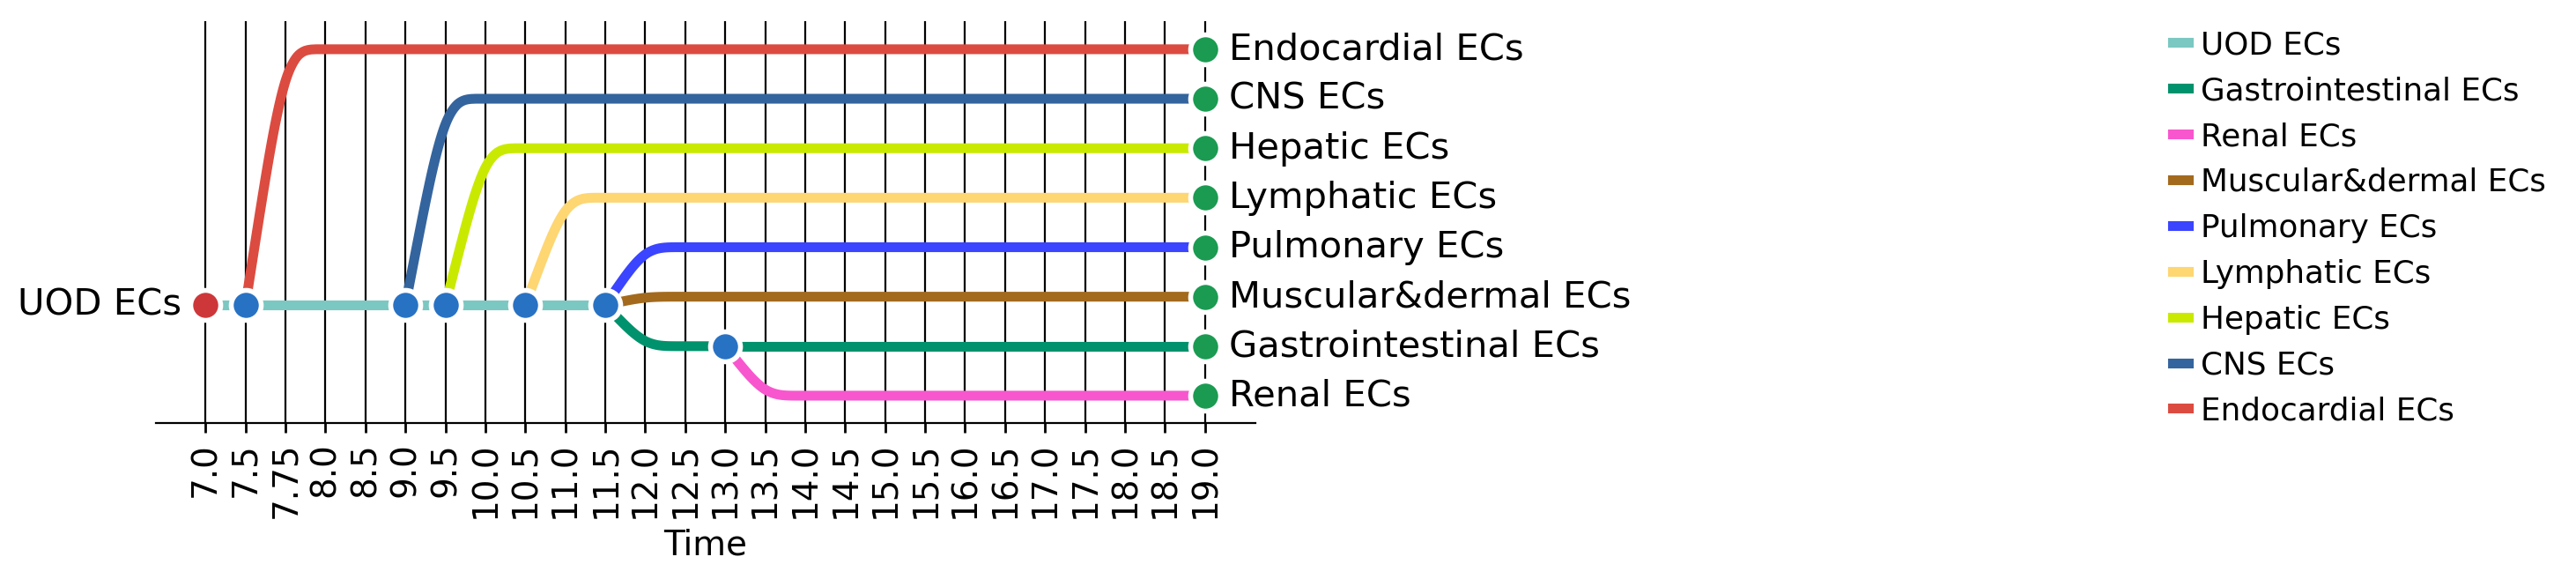

In [18]:
ts.plotTree(cell_type_colors = colors, linewidth = 4, smooth_curve=True,show_loop=True, leaf_label = 'lineage',figsize = (8,3),show_legend=True, bbox_to_anchor=(2.2, 1.05))
ts.plotNodes(s = 150,edgecolor = '#ffffff', linewidth = 2) 

The results of trajectory inference are saved in the __ot_pairs__ folder, which contains three files: __lineages.csv__ records the lineages of all cell types and used to plot the lineage tree. __pair_score.xlsx__ records the transition probabilities of cell types between any adjacent time points, where columns represent the current time point, rows represent the previous time point, and the sum of each column is 1. The pairs with the highest probabilities are selected and recorded in lineages.csv. __sum_score.xlsx__ records the cumulative score of cell transitions calculated based on the Markov chain, i.e., the most probable ancestral cells of all terminal cells at each time point.

In [19]:
ts.trajectory_ds.var_names.values

array(['Endocardial ECs', 'CNS ECs', 'Hepatic ECs', 'Lymphatic ECs',
       'Pulmonary ECs', 'Gastrointestinal ECs', 'Muscular&dermal ECs',
       'Renal ECs'], dtype=object)

In [20]:
ts.save_day_pairs(folder = 'ot_pairs')

OT results are writing to folder ot_pairs...


We observe the transition probability between E13.0 and E13.5

In [21]:
day_pair = (13.5,14.0)

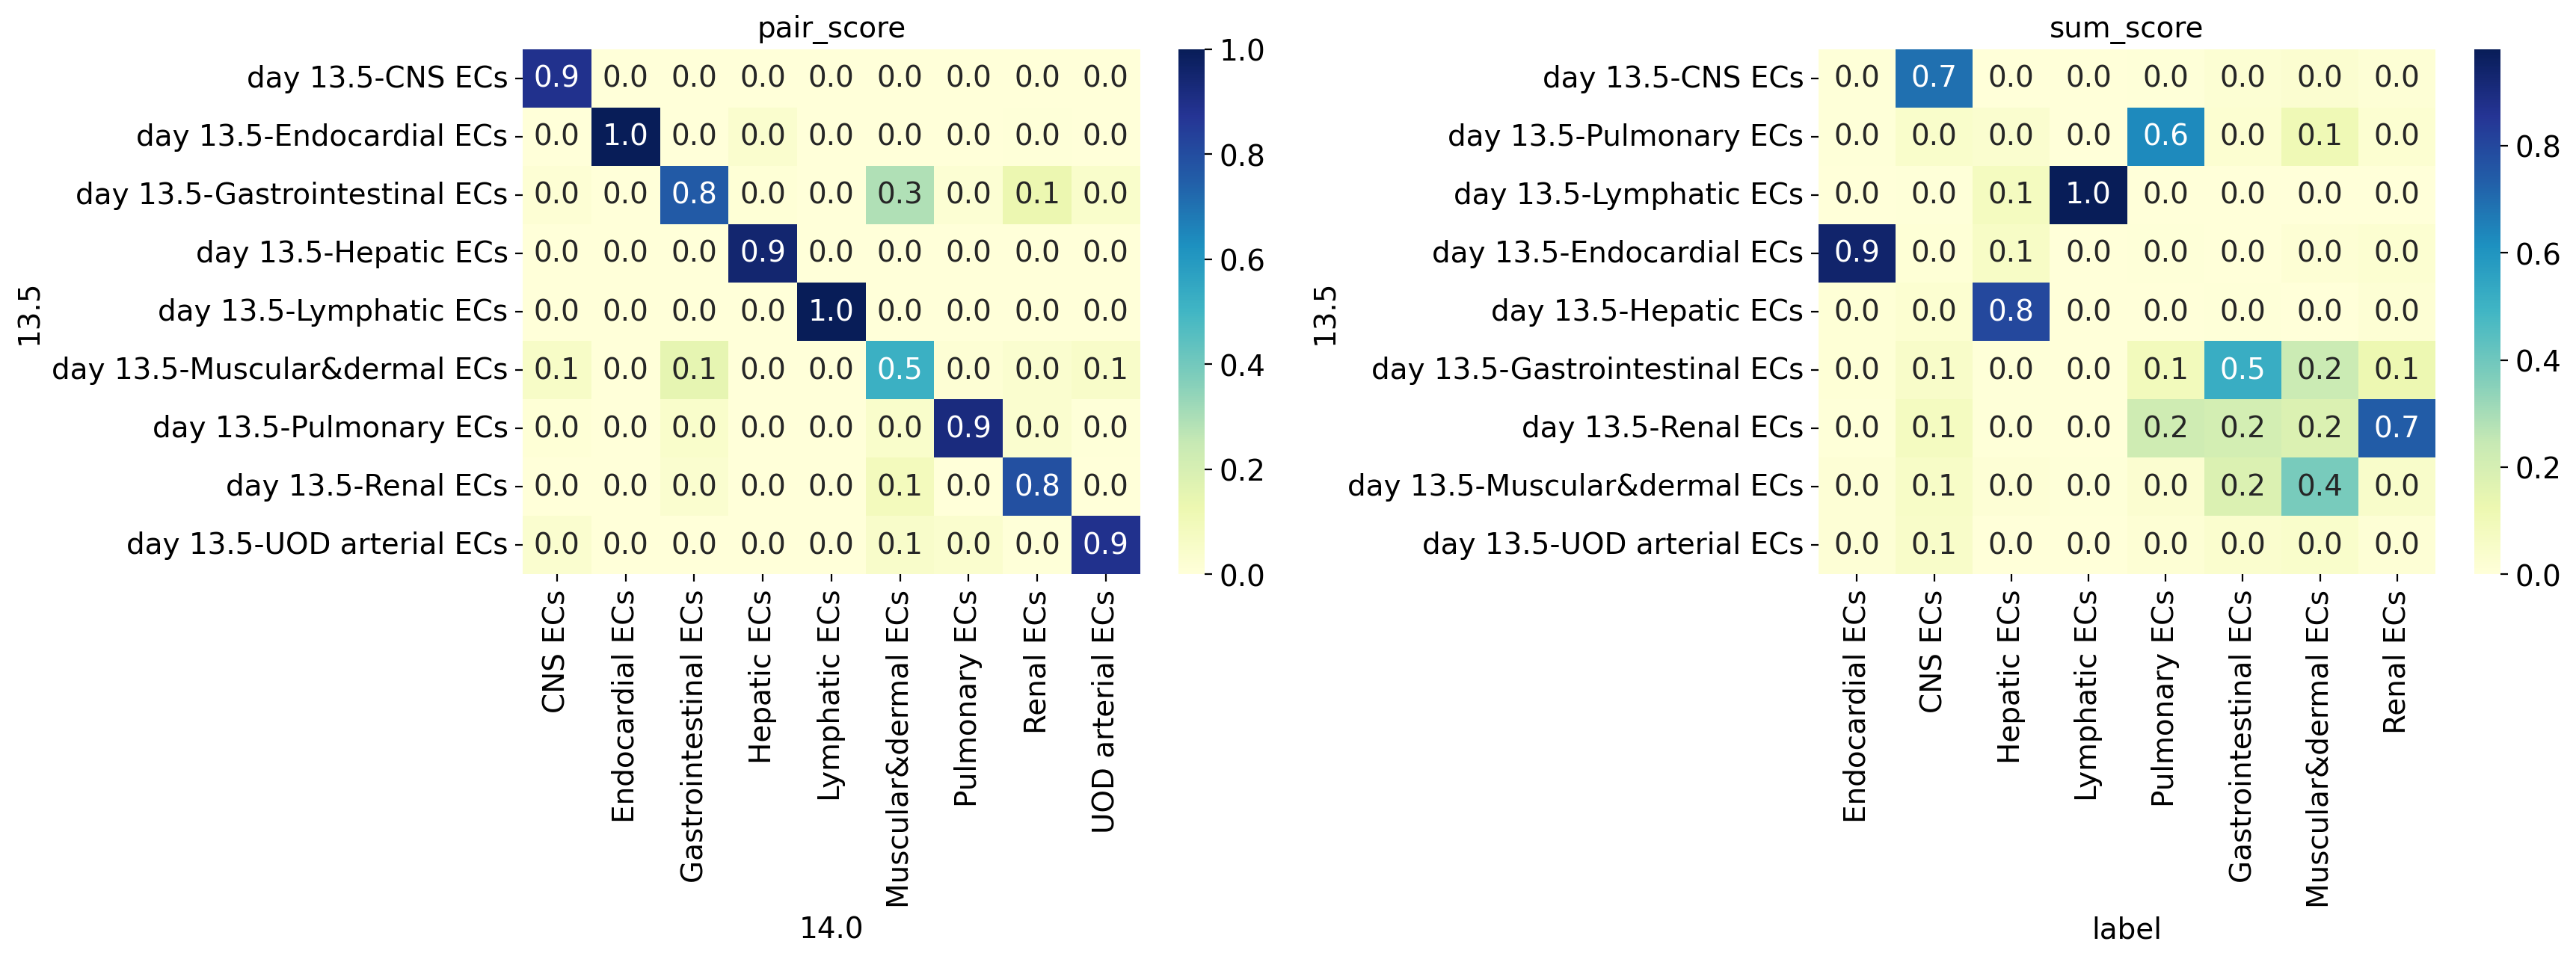

In [22]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize = (18,7),sharey=False)
sns.heatmap(ts.couples[day_pair],annot=True, fmt=".1f", cmap = 'YlGnBu',ax =axs[0]) # pair_score.xlsx
sns.heatmap(ts.sums[day_pair],annot=True, fmt=".1f", cmap = 'YlGnBu',ax =axs[1]) # sum_score.xlsx
axs[0].set_title('pair_score');axs[1].set_title('sum_score')
axs[0].grid(False);axs[1].grid(False)
axs[0].set_ylabel(day_pair[0]);axs[1].set_ylabel(day_pair[0])
axs[0].set_xlabel(day_pair[1]);axs[1].set_xlabel(trajectory_label)
plt.tight_layout(pad=2.0)
plt.show()

## 3. Adjust the trajectory inference

The OT algorithm still suffers from cell number-related biases. Moreover, if an ancestral cell gives rise to two daughter cell types with highly similar gene expression profiles, the algorithm may misclassify one daughter cell type as the ancestral cell. Users should carefully verify trajectories derived from gene expression analyses. In this study, we adjust the lineage links of Renal ECs and Muscular&Dermal ECs to connect them with UOD ECs prior to the E13.0 stage. 

In [23]:
ts.set_lineages('ot_pairs/lineages_new.csv') #lineages_new_with_arterial, lineages_new
ts.buildTree(interpolation=True)

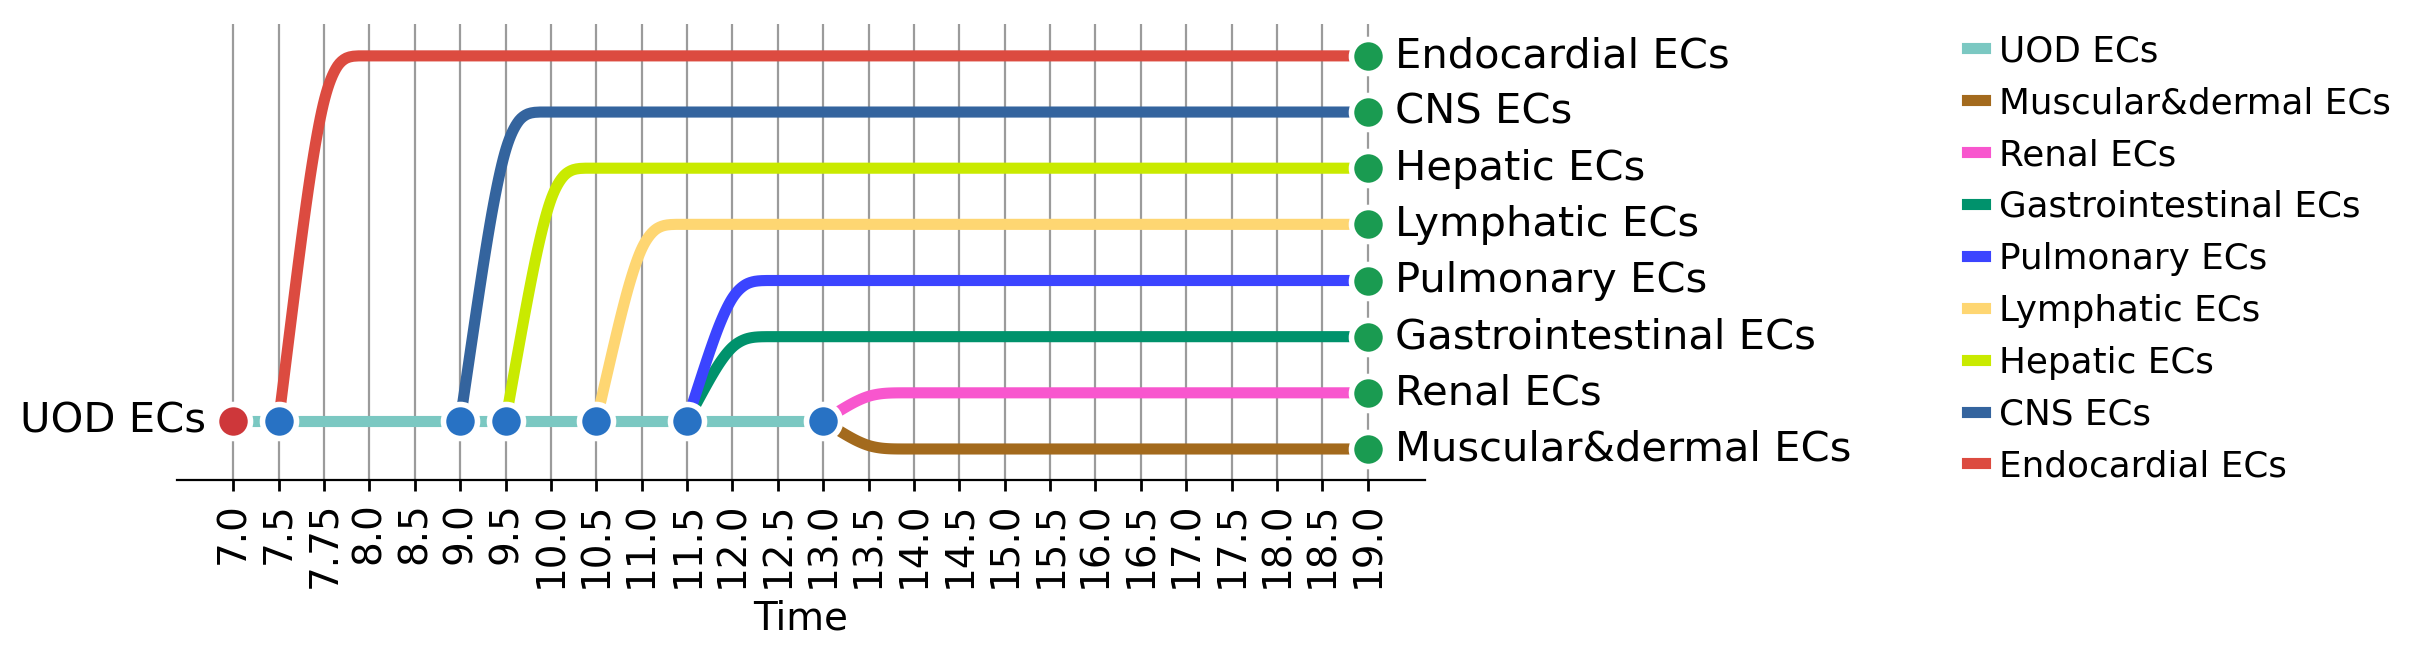

In [24]:
ts.plotTree(cell_type_colors = colors, linewidth = 4,grid_color='#9B9B9B',smooth_curve=True, show_loop=False, leaf_label = 'lineage',figsize = (8,3),show_legend=True, bbox_to_anchor=(1.8, 1.05))
ts.plotNodes(s = 150,edgecolor = '#ffffff', linewidth = 2) 

## 3. Explore gene expression across tree

Calculate the weighted average gene expression and layouts based on Optimal Transport (OT) scores.

In [25]:
ts.aveGeneExp()

In [26]:
genes = ['Tmem108','Foxq1','Oit3','Prox1','Scn7a','Nkx2-3','Irx3','C1qtnf9','Casz1','Fgf1']

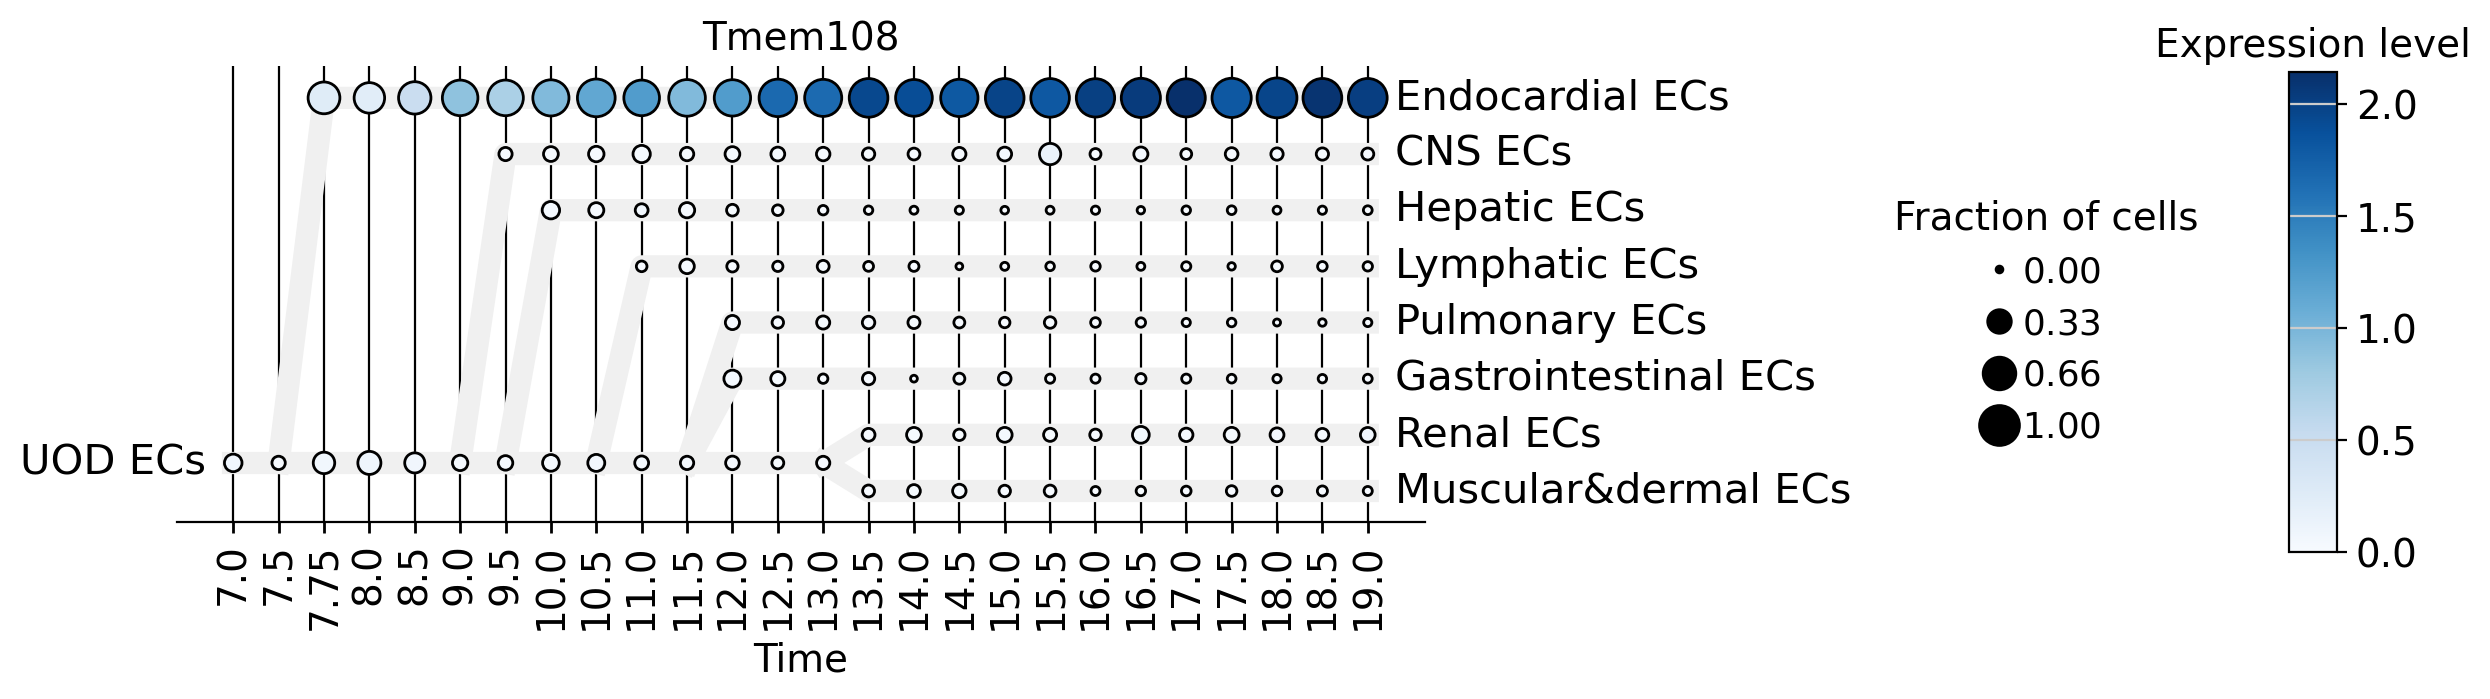

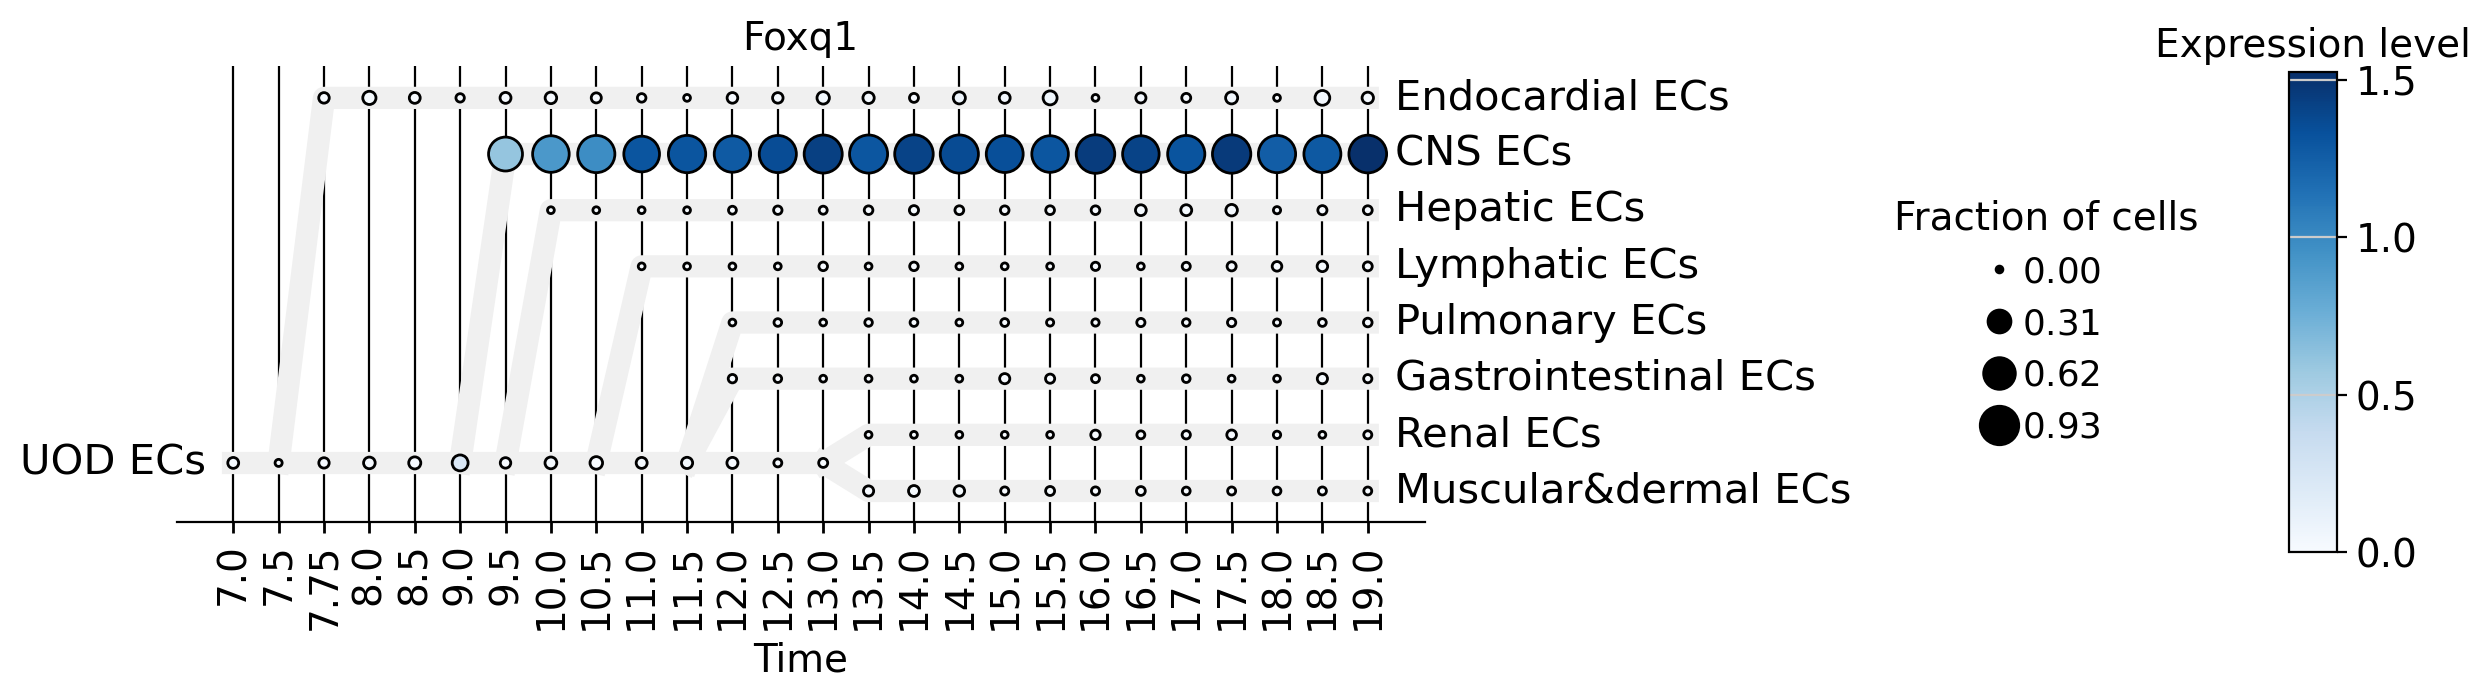

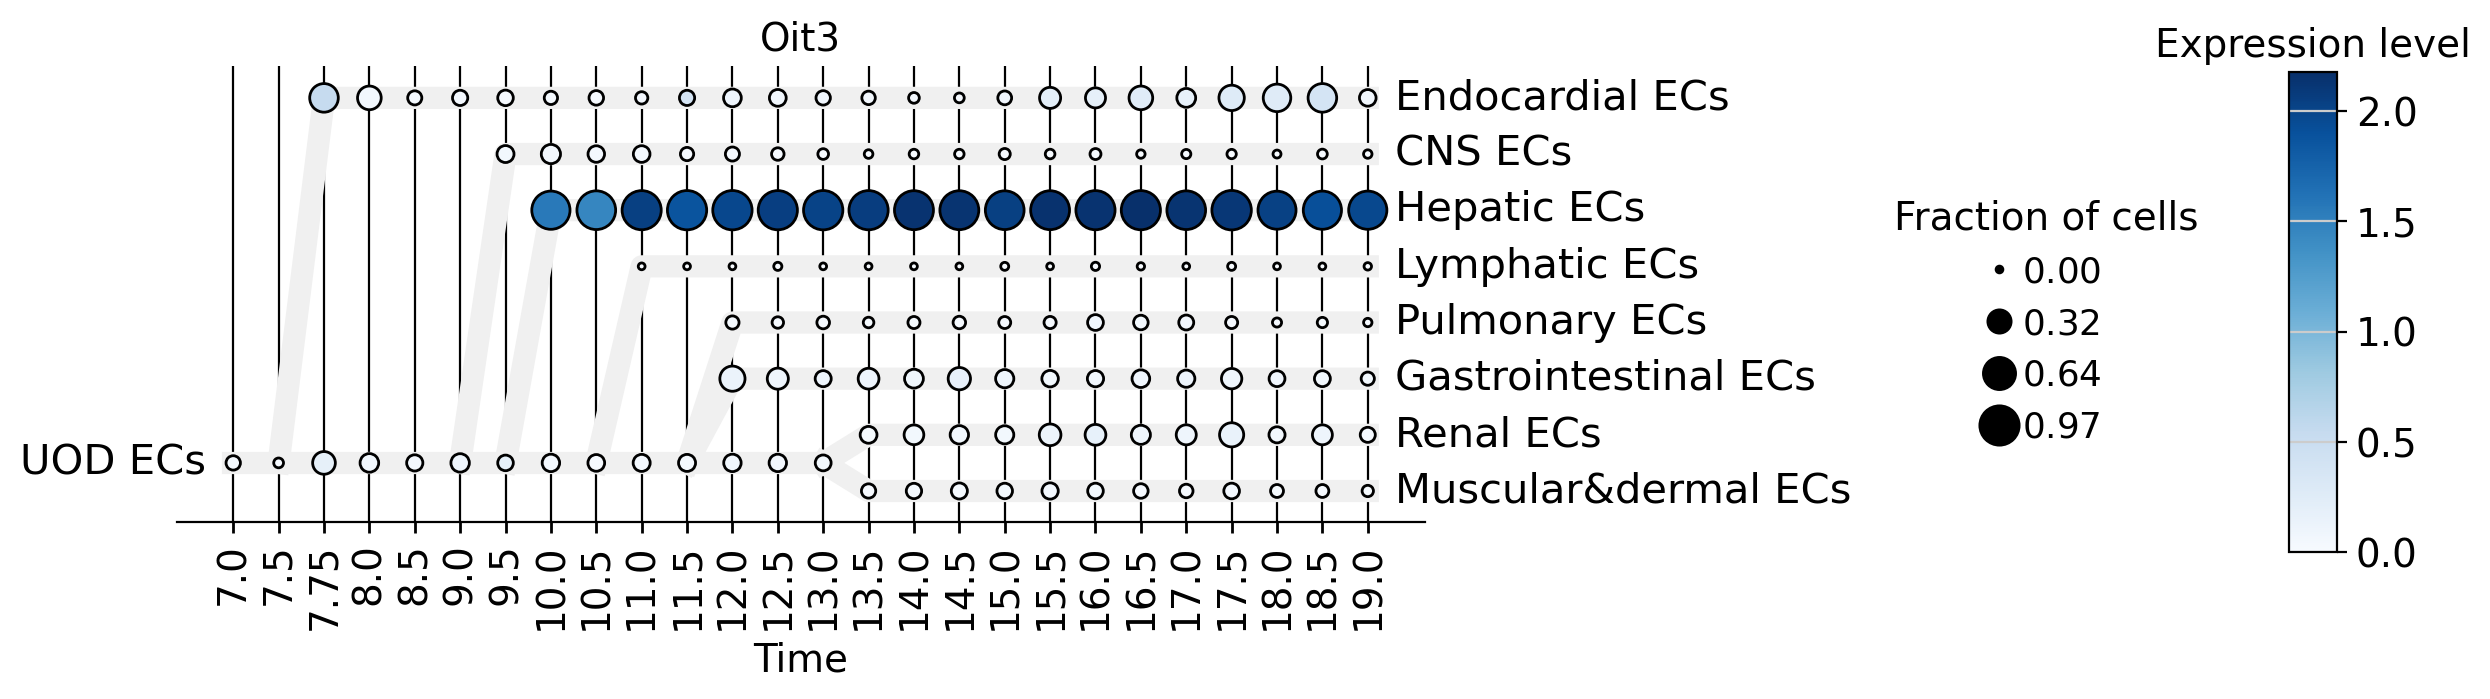

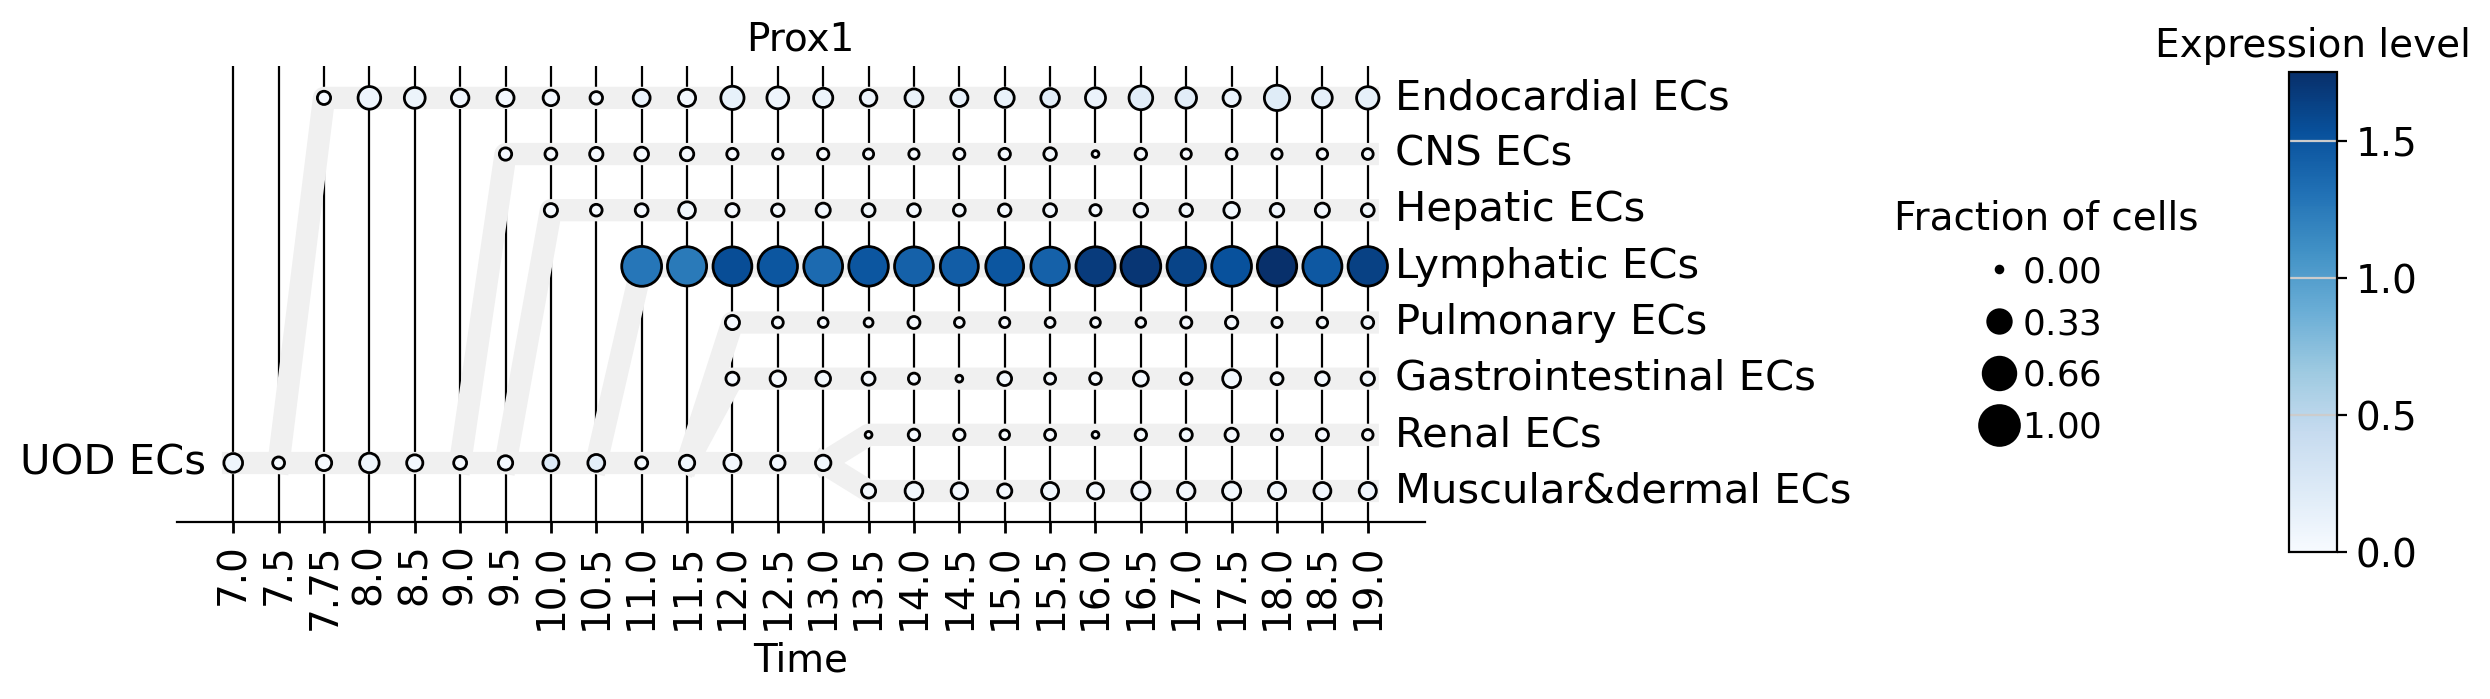

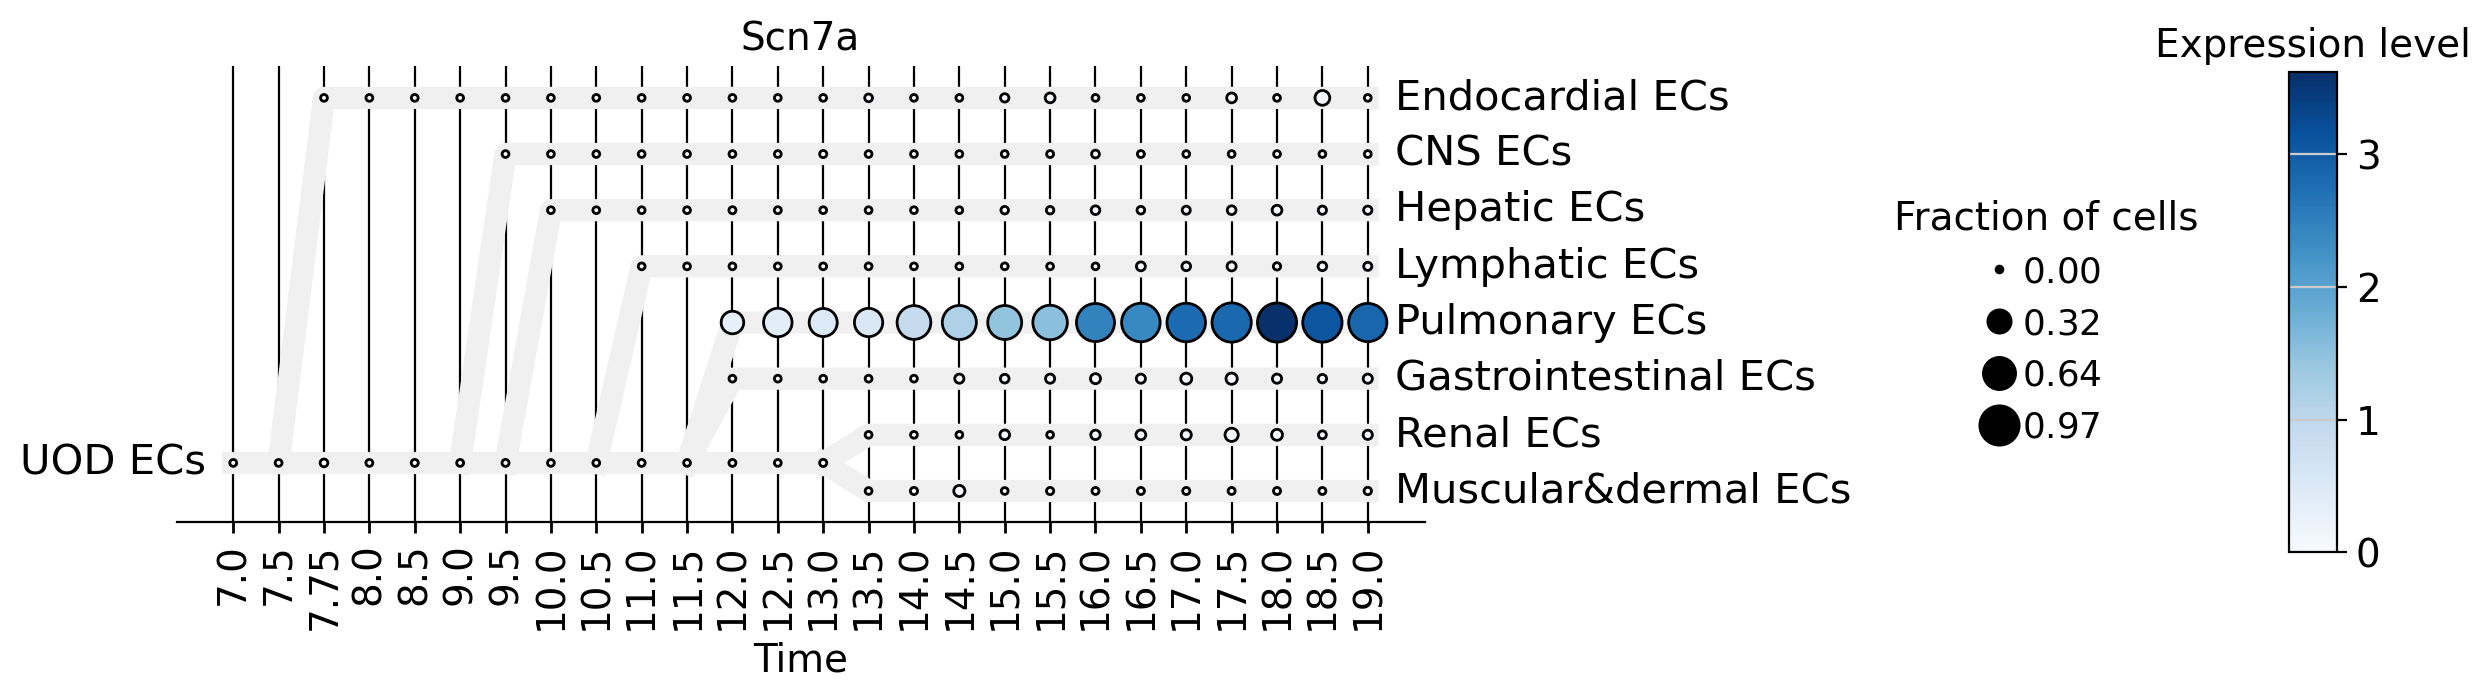

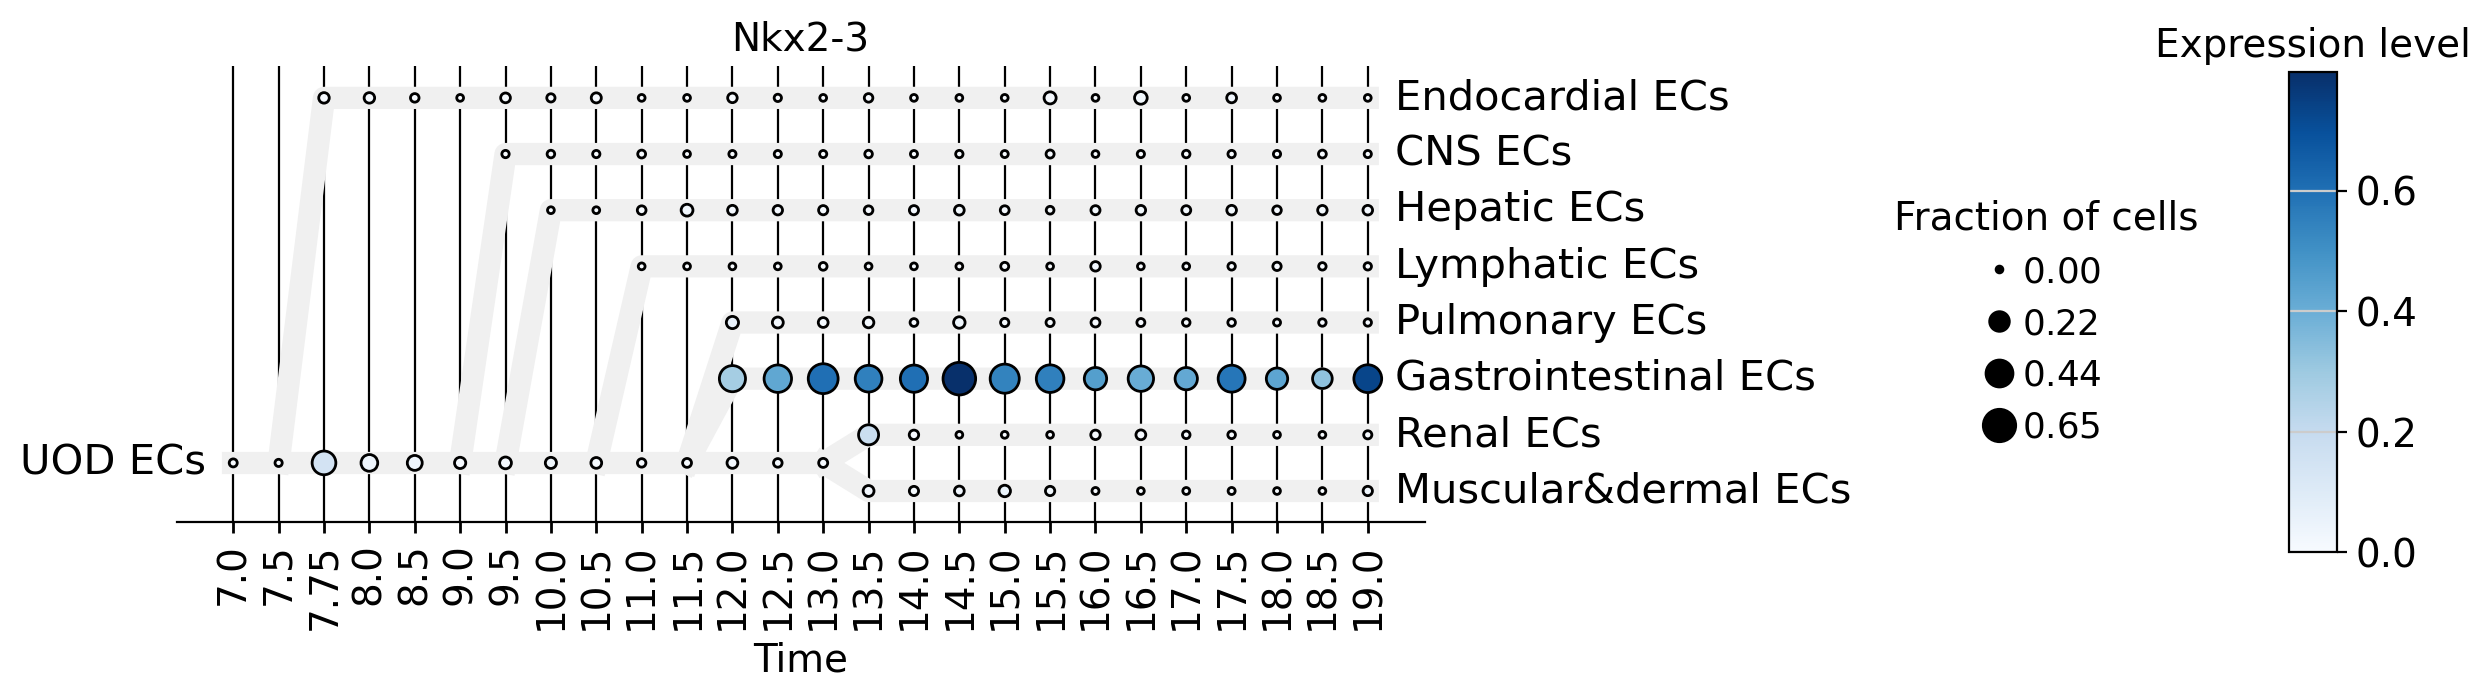

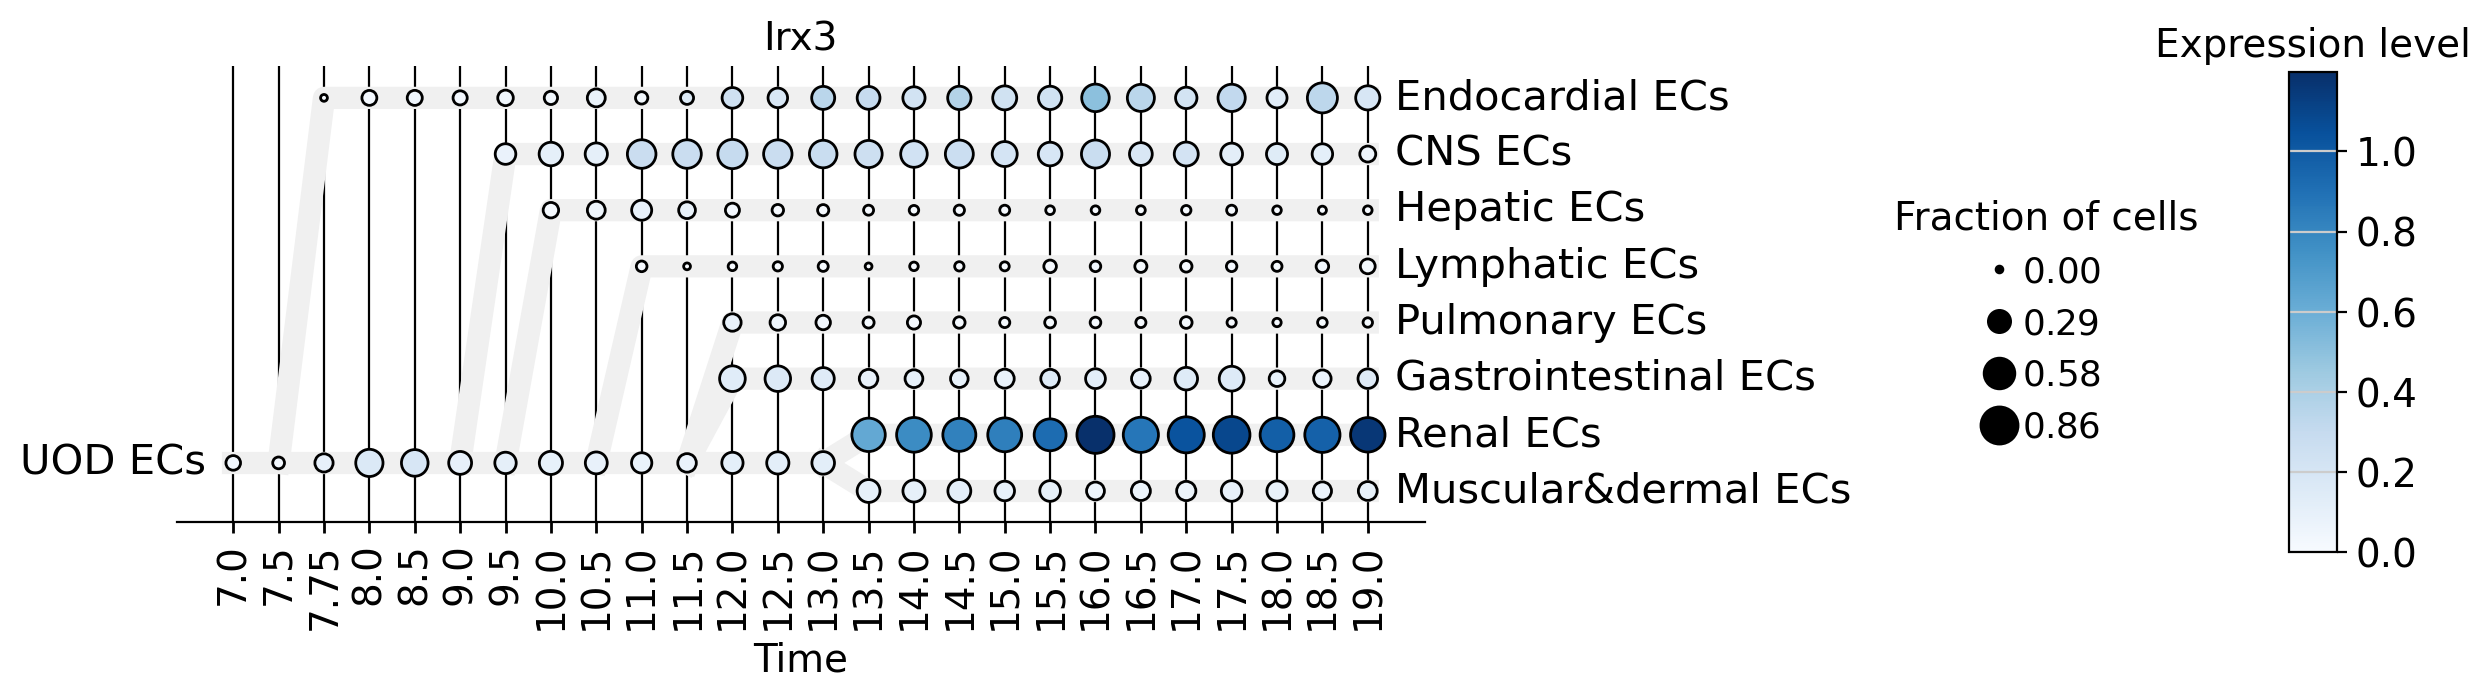

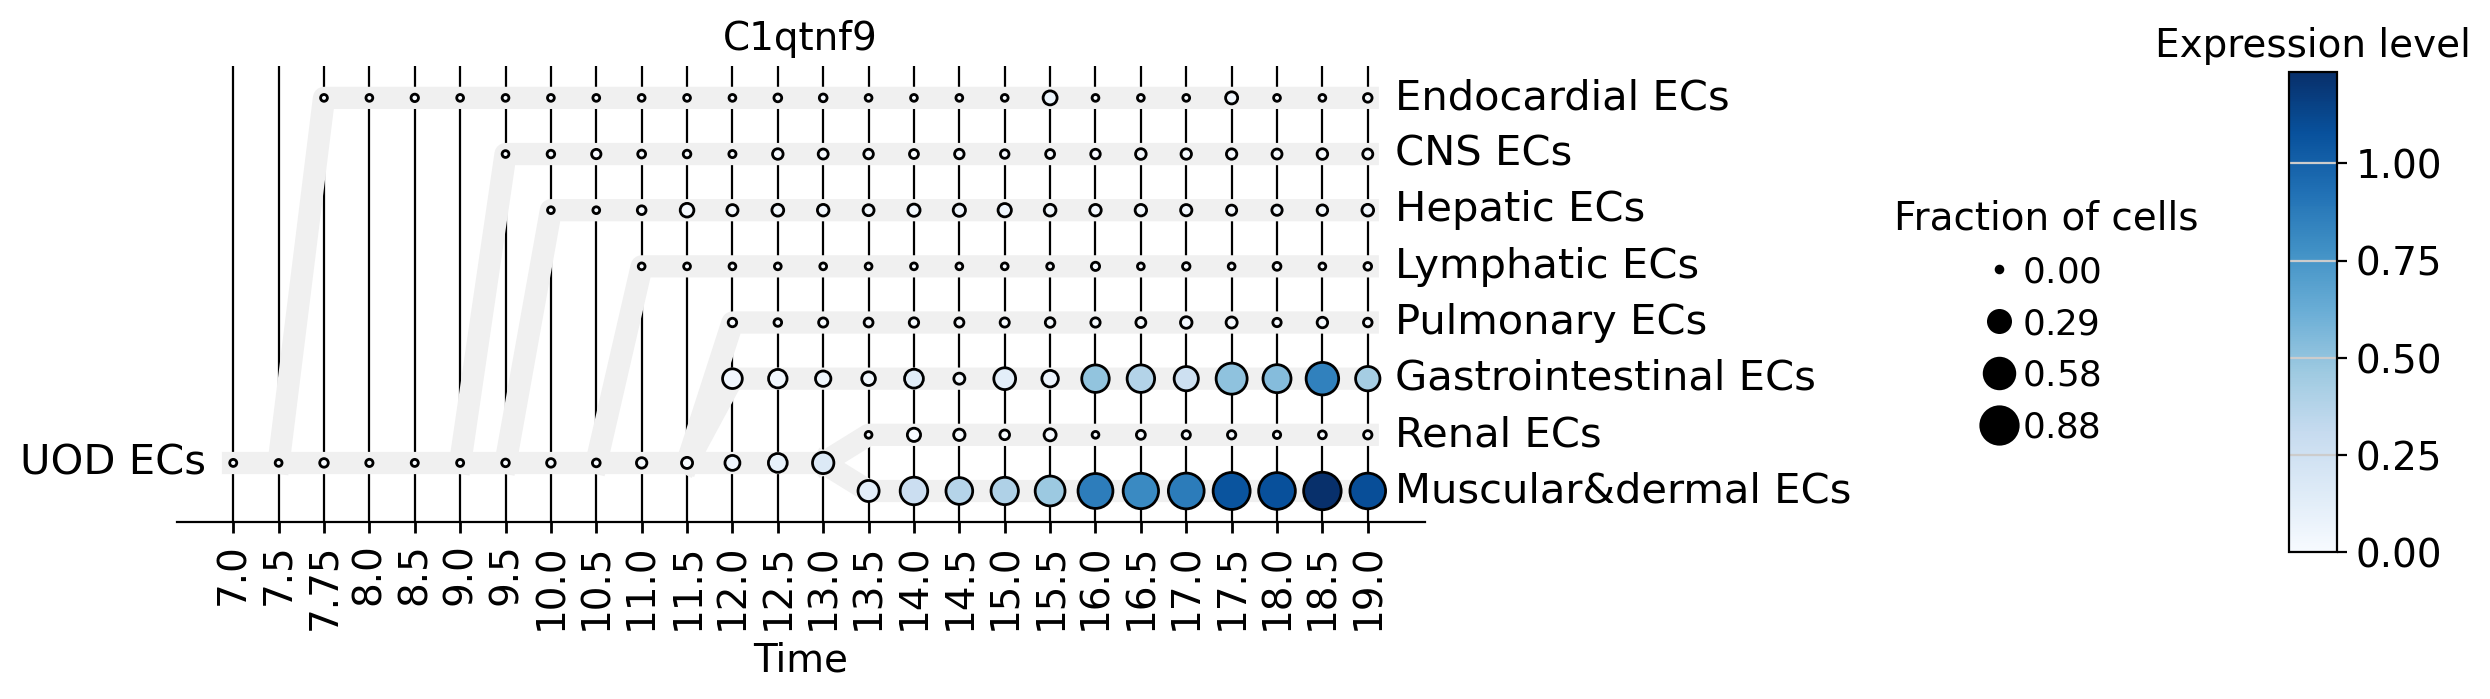

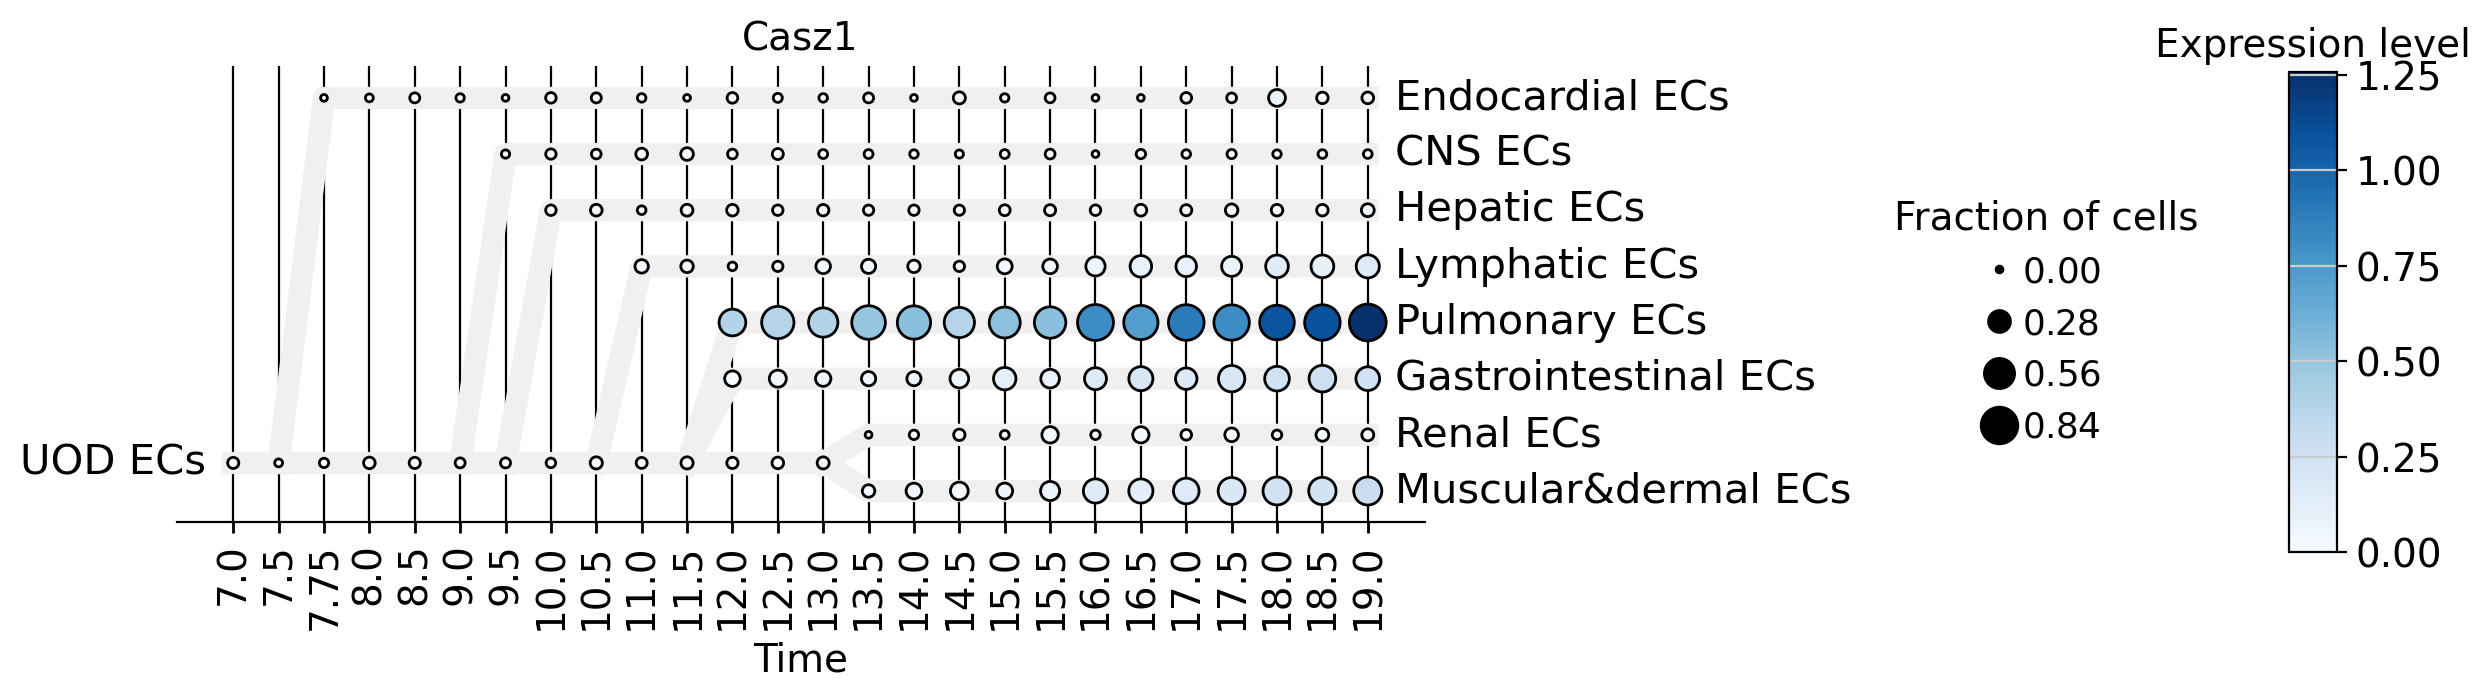

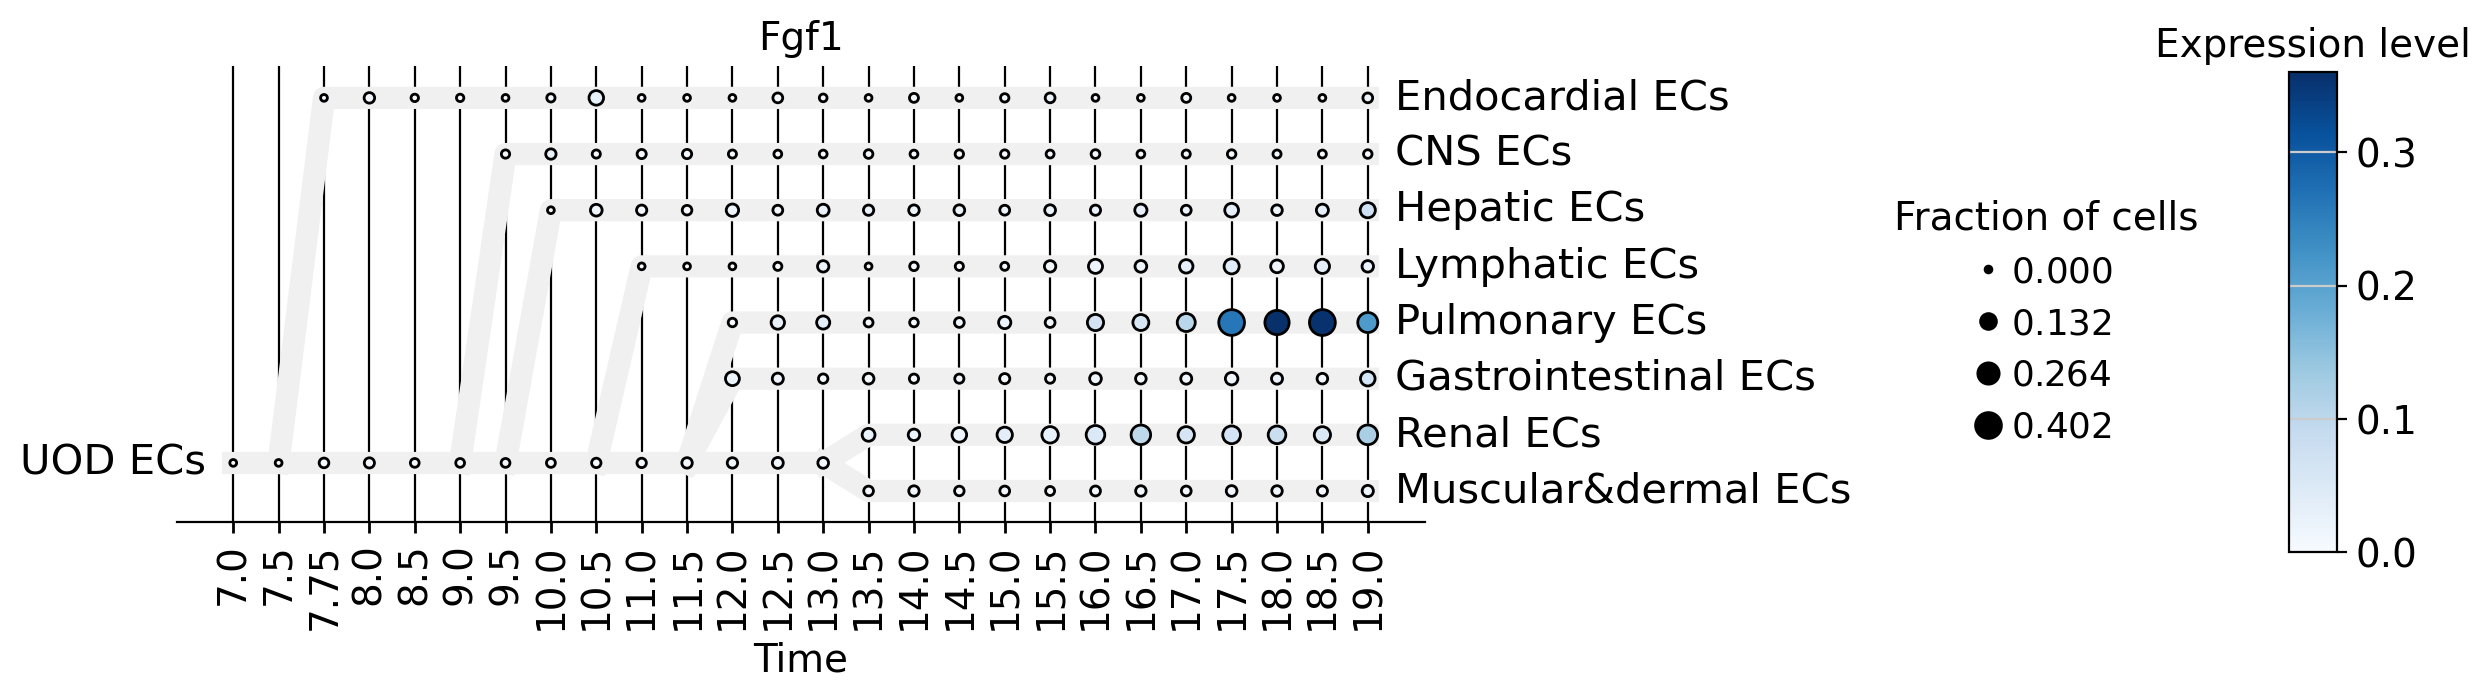

In [27]:
smallest_size = 0.03 
for gene in genes:
    center = None
    ts.plotTree(cell_type_colors = None,adjust_layout = True,smooth_curve=False, linewidth = 8, 
                show_loop=False, leaf_label = 'leaf',figsize = (8,3),show_legend=True, bbox_to_anchor=(9.2, 10.05))
    ts.plotExprs( gene = gene,center = center, size = 200,smallest_size = smallest_size,cmap = 'Blues',
                 legend_pos = (1.35, 0.1),colorbar_pos = [1.5, 0.1, 0.03, 0.8],num_of_legend_dots=4)
    ts.ax.set_title(gene)

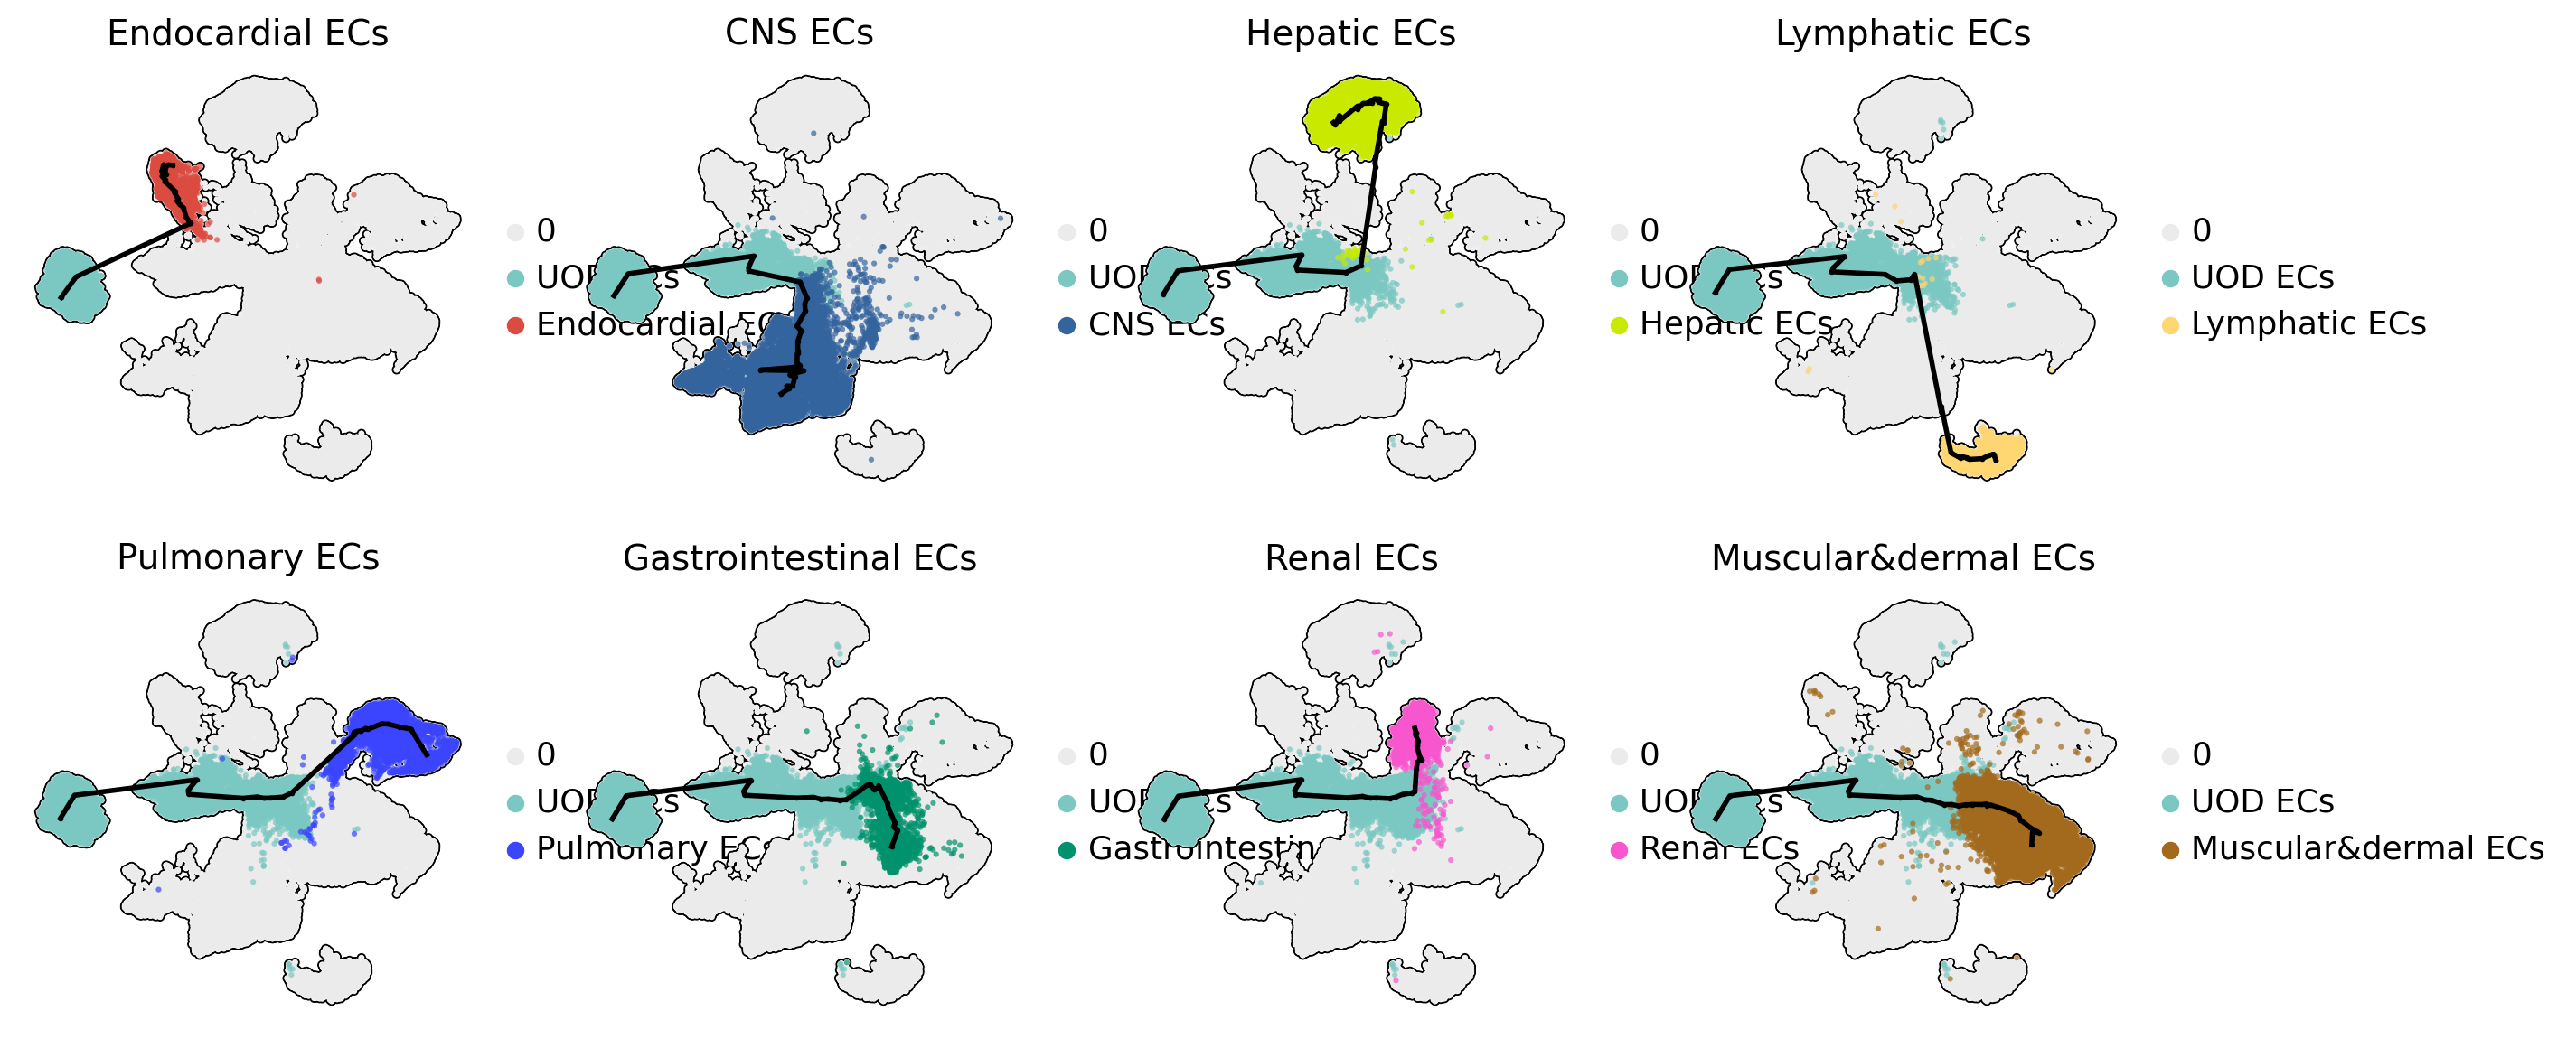

In [28]:
ts.trajectoryPlot(color= 'label',basis = 'X_umap', style='split',ncol = 4,dotcolor='time',
                  linecolor = '#000000',edgewidth=1, point_size=1,linewidths = 2,size = 20,
                  figsize = (15,7))